<center><h1> DSCI 100: Project Proposal </center></h1>
    
<center><h3> Group 27 </center></h3>

<hr>

## Libraries

In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

<br>
<hr>

## 1. Introduction

Auditing is the examination of businesses financial records to determine if they align with standard accounting laws and principles (Hooda, 2019). Certain factors of a business or firm, such as historical discrepancy between a financial report and an audit inspection can help auditors identify those that are higher risk for fraudulent activity. This dataset contains information about 777 firms, each of which are either classified as “Fraud” firms, or “Non-fraud” firms. In terms of features, we have 27 numeric features one of which is the binary "Risk"".

The dataset aims to aid in the auditing process, by providing insight into whether a particular firm is “high risk” (in which case auditors would want to visit the firm) or “low risk” (in which case auditors may skip visiting that firm). Some of the risk factors examined in the dataset include discrepancies in reports, historical discrepancy scores, and amounts of money involved in misstatements. With this dataset, we will implement a K-nearest-neighbors classification model to identify \"Fraud\" firms from unseen datasets. 

### 1a. Feature Descriptions

| -**Inherent risk factors**- |                                                                                               | -**Control risk factors**- |                                                                                     |
|-----------------------|-----------------------------------------------------------------------------------------------------|----------------------|-------------------------------------------------------------------------------------------|
| **Feature**           | Information                                                                                         | **Feature**          | Information                                                                               |
| Para A value          | Discrepancy found in the planned-expenditure of inspection and summary report A in Rs (in crore).   | Sector score         | Historical risk score value of the target-unit in the Table 1 using analytical procedure. |
| Para B value          | Discrepancy found in the unplanned-expenditure of inspection and summary report B in Rs (in crore). | Loss                 | Amount of loss suffered by the firm last year.                                            |
| Total                 | Total amount of discrepancy found in other reports Rs (in crore).                                   | History              | Average historical loss suffered by firm in the last 10¬†years.                           |
| Numbers                | Historical discrepancy score.                                                                       | District loss      | Historical risk score of a district in the last 10¬†years.                                |
| Money value           | Amount of money involved in misstatements in the past audits.                                       |                      |                                                                                           |


| **Other features**    |                                                                                                     |                      |                                                                                           |
|-----------------------|-----------------------------------------------------------------------------------------------------|----------------------|-------------------------------------------------------------------------------------------|
| **Feature**           | Information                                                                                         | **Feature**          | Information                                                                               |
| Sector ID             | Unique ID of the target sector.                                                                     | Location ID          | Unique ID of the city/province.                                                           |
| ARS                   | Total risk score using analytical procedure.                                                        |              |                                           |
| Risk class            | Risk Class assigned to an audit-case. (Target Feature) [0 = non-fraud, 1 = fraud]                                              |                      |                                                                                           |

<br></br>
**Note.** The \"Inherent_Risk\" and \"Control_risk\" factors are the aggregated sums of the factors in the categories above.

<br> 
<hr>

## 2. Preliminary EDA
### 2a. Reading Data

In [15]:
audit <- read_csv("https://raw.githubusercontent.com/montajesaj1/DSCI100-G27/main/audit_data/audit_risk.csv") 
audit <- audit |> mutate(Risk = as.factor(Risk), LOCATION_ID = as.factor(LOCATION_ID))
head(audit)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6,⋯,0.4,0,0.2,0,4.4,17.530,0.4,0.5,3.5060,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0


### 2b. Tidying the Data and Changing Data-types

In [3]:
audit_tidy <- audit |>
  pivot_longer(cols = starts_with("PARA_"), names_to = "discrepancy", values_to = "discrepancy_value") |>
  pivot_longer(cols = starts_with("Score_"), names_to = "score_variable", values_to = "score_value") |>
  pivot_longer(cols = starts_with("Risk_"), names_to = "risk_variable", values_to = "risk_value")

head(audit_tidy)

# **Note.** new columns `risk_variable` and `risk_value` account for the previous risk variables and their associated scores when tidying the data. Likewise, `discrepancy` and `discrepancy_value` are for the initial PARA features tidied

Sector_score,LOCATION_ID,TOTAL,numbers,Money_Value,District_Loss,PROB,History,Prob,Score,⋯,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk,discrepancy,discrepancy_value,score_variable,score_value,risk_variable,risk_value
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_A,2.508
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_B,0.500
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_C,1.000
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_D,0.676
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,RiSk_E,0.400
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_F,0.000


### 2c. Train/Test Split

In [4]:
risk_split <- initial_split(audit_tidy, prop = 0.75, strata = Risk)
risk_train <- training(risk_split)
risk_test <- testing(risk_split) 

### 2d. Summary Tables

#### **Table 1:** Comparing counts for each class of the Target Feature

In [5]:
table_1 <- risk_train |>
    group_by(Risk) |>
    summarize(Count = n())

table_1

Risk,Count
<fct>,<int>
0,16956
1,10980


#### **Table 2/3:** Summary Statistics on all Features and Missing Value Counts

In [6]:
summary <- risk_train |>
    summary()
summary

  Sector_score    LOCATION_ID        TOTAL            numbers     
 Min.   : 1.85   8      : 2735   Min.   :   0.00   Min.   :5.000  
 1st Qu.: 2.37   19     : 2466   1st Qu.:   0.53   1st Qu.:5.000  
 Median : 3.89   16     : 1890   Median :   1.37   Median :5.000  
 Mean   :20.30   9      : 1873   Mean   :  13.25   Mean   :5.068  
 3rd Qu.:55.57   12     : 1704   3rd Qu.:   7.69   3rd Qu.:5.000  
 Max.   :59.85   5      : 1575   Max.   :1268.91   Max.   :9.000  
                 (Other):15693                                    
  Money_Value     District_Loss        PROB           History      
 Min.   :  0.00   Min.   :2.000   Min.   :0.2000   Min.   :0.0000  
 1st Qu.:  0.00   1st Qu.:2.000   1st Qu.:0.2000   1st Qu.:0.0000  
 Median :  0.09   Median :2.000   Median :0.2000   Median :0.0000  
 Mean   : 13.97   Mean   :2.506   Mean   :0.2062   Mean   :0.1037  
 3rd Qu.:  5.49   3rd Qu.:2.000   3rd Qu.:0.2000   3rd Qu.:0.0000  
 Max.   :935.03   Max.   :6.000   Max.   :0.6000   Max. 

In [7]:
missing_values_counts <- risk_train |>
  select(where(~any(is.na(.)))) |>
  summarise(across(everything(), ~sum(is.na(.)), .names = "missing_count_{.col}"))

missing_values_counts

missing_count_Money_Value
<int>
33


**Note.** There is only one feature missing values `Money_value` 

### 2.e Investigative Plots

#### Plot 1: Scatter Plot [Total vs Inherent Risk]

Warning message:
“Transformation introduced infinite values in continuous x-axis”


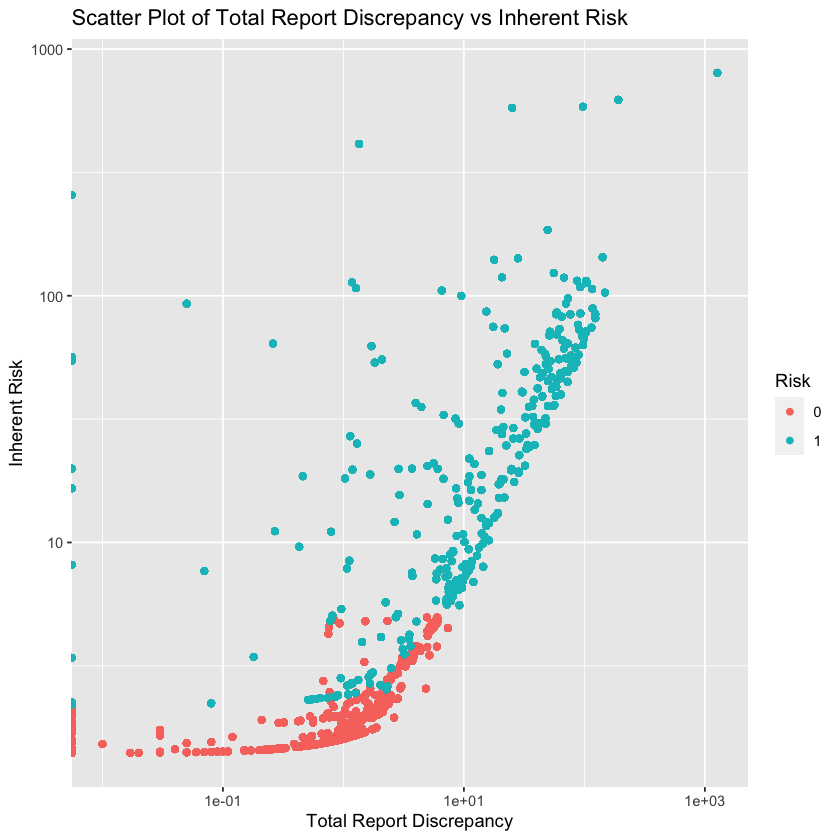

In [8]:
feature_plot1 <- risk_train |> ggplot(aes(x = TOTAL, y = Inherent_Risk, color = Risk)) + geom_point() + scale_x_log10() + scale_y_log10() +
    ggtitle('Scatter Plot of Total Report Discrepancy vs Inherent Risk') +
    xlab('Total Report Discrepancy') +
    ylab('Inherent Risk')

feature_plot1

#### Plot 2: Scatter Plot [Total vs Money Value]

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 33 rows containing missing values (`geom_point()`).”


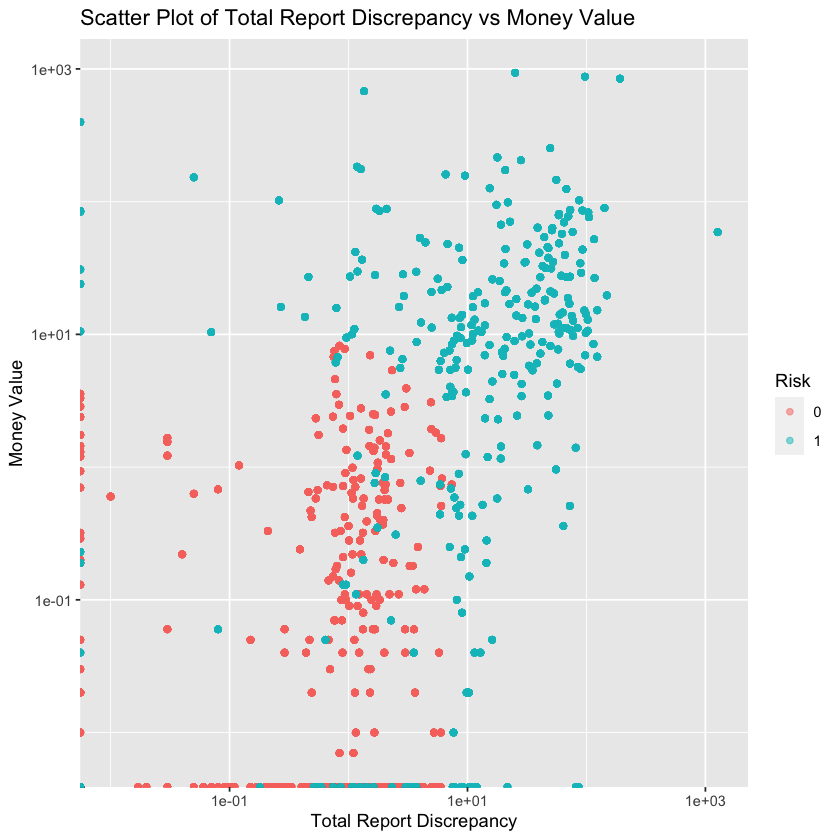

In [9]:
feature_plot2 <- ggplot(risk_train, aes(x = TOTAL, y = Money_Value)) +
  geom_point(aes(color = Risk), alpha = 0.5) +
  scale_x_log10() + scale_y_log10() +
  ggtitle('Scatter Plot of Total Report Discrepancy vs Money Value') +
  xlab('Total Report Discrepancy') +
  ylab('Money Value')

feature_plot2

#### Plot 3: Bar Chart [Location ID total counts showing Risk]

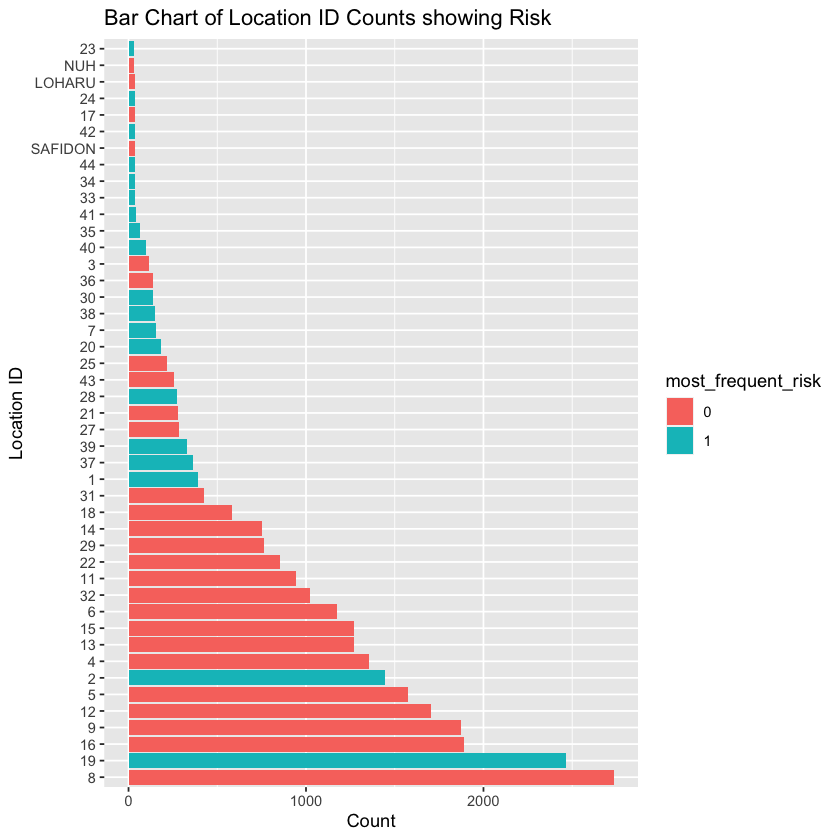

In [10]:
feature_plot3 <- risk_train |>
  group_by(LOCATION_ID, Risk) |>
  summarise(count = n(), .groups = "drop") |>
  group_by(LOCATION_ID) |>
  summarise(total = sum(count), most_frequent_risk = Risk[which.max(count)]) |>
  ungroup() |>
  mutate(LOCATION_ID = reorder(LOCATION_ID, -total)) |>
  ggplot(aes(y = LOCATION_ID, x = total, fill = most_frequent_risk)) +
    geom_bar(stat = "identity", position = "dodge") +
    ggtitle("Bar Chart of Location ID Counts showing Risk") +
    ylab("Location ID") +
    xlab("Count") 

feature_plot3

#### Plot 4: Bar Chart [Bar Chart of Score Variables and Corresponding Values showing Risk]

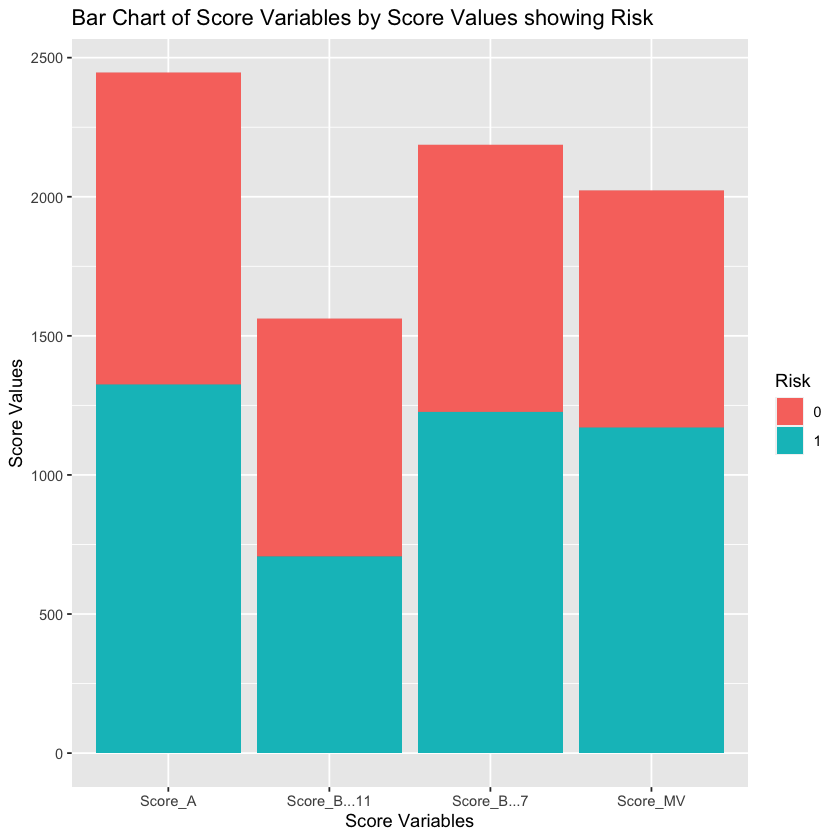

In [11]:
feature_plot4 <- risk_train |>
  ggplot(aes(y = score_value, x = score_variable, fill = Risk)) +
    geom_bar(stat = "identity", position = "stack") +
    ggtitle("Bar Chart of Score Variables by Score Values showing Risk") +
    ylab("Score Values") +
    xlab("Score Variables") 

feature_plot4

#### Plot 5: Bar Chart [Bar Chart of Discrepancy Variables and Corresponding Values showing Risk]

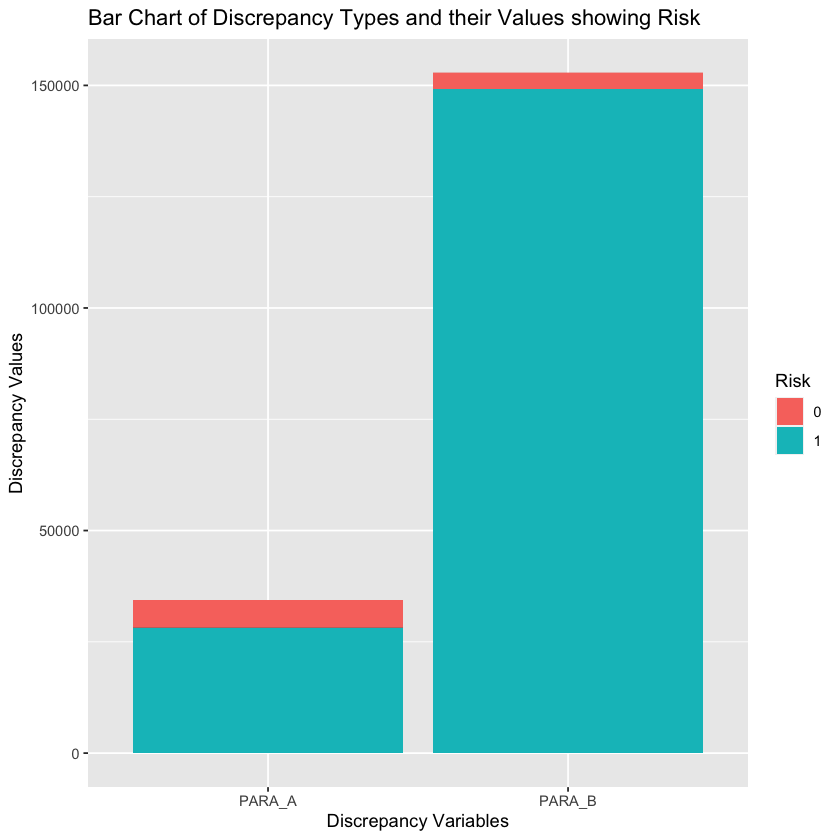

In [12]:
feature_plot5 <- risk_train |>
  ggplot(aes(y = discrepancy_value, x = discrepancy, fill = Risk)) +
    geom_bar(stat = "identity", position = "stack") +
    ggtitle("Bar Chart of Discrepancy Types and their Values showing Risk") +
    ylab("Discrepancy Values") +
    xlab("Discrepancy Variables") 

feature_plot5

#### Plot 6: Bar Chart [Bar Chart of History vs District Loss]

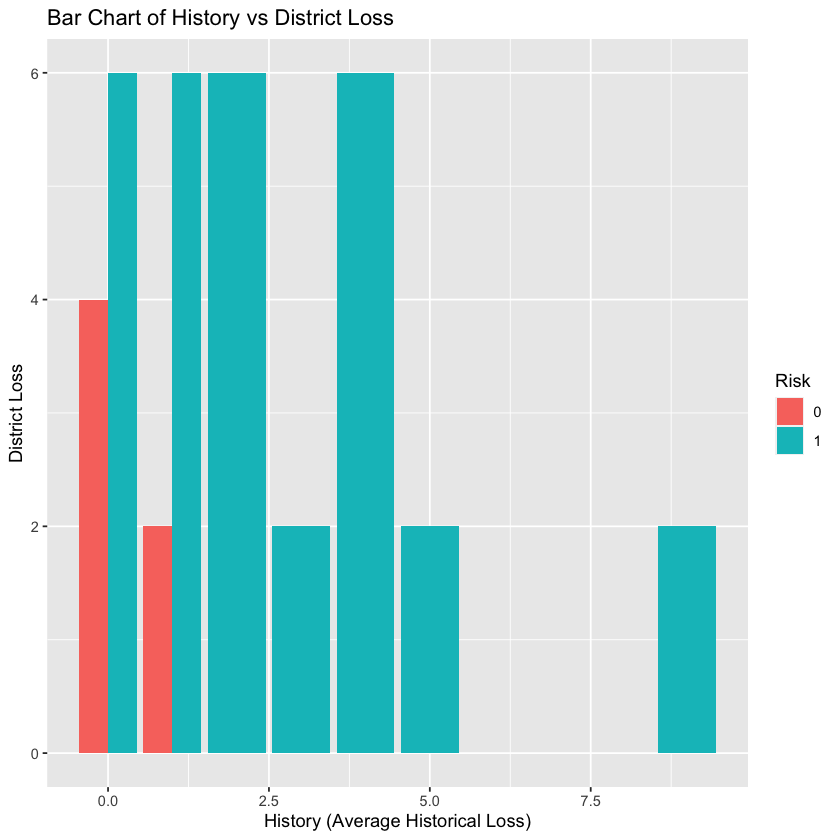

In [13]:
feature_plot6 <- risk_train |> ggplot(aes(x = History, y = District_Loss, fill = Risk)) + geom_bar(stat= "identity", position="dodge") +
    ggtitle('Bar Chart of History vs District Loss') +
    xlab('History (Average Historical Loss)') +
    ylab('District Loss')

feature_plot6

<br>
<hr>

## 3. Methods

We will use the K-nearest neighbour algorithm to build the classifier for our data. We want to find the number of neighbours that will give us the most accurate classification results. By first splitting the data into a training set and a test set, we can then split the training data into a sub training set and a validation set to perform a cross validation. Following this we will create a recipe, selecting Risk as our target class and Total, Inherent Risk, Money Value, History, Score Variables/Values and Location ID as our predictors. When creating our model using the KNN algorithm, we will set neighbours = tune() so that our cross validation can calculate an accuracy for multiple values of K. We will combine this model with the recipe into a workflow to train the classifier, then visualize the results (which number of neighbours is appropriate) by plotting the accuracy estimates against the number of neighbors. When building our KNN classifier for the dataset, we will use the number of neighbours will give us the most accurate predictions. 

<br>
<hr>

## 4. Expected Outcomes and Significance 

From our work, we expect to find that Total, Inherent Risk, Money Value, and Location ID are strong predictors of whether or not a firm is fraudulent. 
We expect to find a method to accurately classify the unclassified firms as fraudulent or non-fraudulent firms. Our findings will reduce the workload for auditors by helping them easily classify firms into risky or non-risky, making their auditing process more efficient. Our findings may also reveal which factors are the most important to predicting the riskiness of various businesses and firms. Furthermore, our findings could help provide a guideline for companies to be audited on what activities and processes to avoid. 

Future work could also be done into classifying firms in good financial health and whether or not fraudulent activities are correlated with a firm's financial health. Another future question we could answer is whether or not these findings hold outside of India. Are the predictors that we used here equally effective in say the USA or the UK?

References: 
Audit data. UCI Machine Learning Repository. (n.d.). https://archive.ics.uci.edu/dataset/475/audit+data 

Hooda, N., Bawa, S., &amp; Rana, P. S. (2018). Fraudulent firm classification: A case study of an external audit. Applied Artificial Intelligence, 32(1), 48–64. https://doi.org/10.1080/08839514.2018.1451032 

<br>
<hr>